필수
- 데이터프레임 결측치와 데이터 타입 확인 및 처리<br>
- 레그플롯과 박스 플롯을 통한 이상치 확인<br>
- 기술통계 및 도수분포표를 통한 이상치 확인 및 제거<br>
- 이상치 제거 후 레그플롯으로 확인<br>
- 스케일링 전 신뢰구간 확인 후 시각화<br>
- 정규분포가정(정규성 검정 대체)<br>
- 표준화-정규화(scaling)<br>
- 주성분 분석(PCA)<br>
- 상관분석<br>
- 회귀분석<br>
- 분석 결과 그래프 및 차트 제시

사용할 분석방법 후보
- 피어슨 상관분석, 회귀분석(단순회귀,다중회귀), 로지스틱 등

귀무가설: 총생활비와 y값의 상관이 없다.<br>
대립가설: 총생활비는 y값과 상관이 있다.

패키지 준비

In [1]:
from pandas import read_excel, DataFrame, merge, cut
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency,t
import statsmodels.api as sm

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import myOls, getConfidenceInterval, pearson_r, spearman_r

In [2]:
# 데이터 준비
df=read_excel("세미프로젝트3.xlsx")
df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [3]:
#원본 데이터 유지하기 위해 카피본 생성
df1=df.copy()

In [4]:
#각 변수 데이터타입 확인하기
df1.dtypes

총생활비             int64
이자_배당금_연간소득    float64
임대료_연간소득         int64
기타_소득          float64
세금환급금          float64
금융기관대출           int64
주거관련_부채의_이자      int64
주택관련_부채액       float64
공적연금_연간소득        int64
dtype: object

for문으로 컬럼 돌려서 수치가 0인값, 0이 아닌 값 확인

In [5]:
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    print('0 아닌 수 :',{column : number_count})
    print('-'*30)

0 개수 : {'총생활비': 0}
0 아닌 수 : {'총생활비': 7865}
------------------------------
0 개수 : {'이자_배당금_연간소득': 5489}
0 아닌 수 : {'이자_배당금_연간소득': 2376}
------------------------------
0 개수 : {'임대료_연간소득': 6707}
0 아닌 수 : {'임대료_연간소득': 1158}
------------------------------
0 개수 : {'기타_소득': 1439}
0 아닌 수 : {'기타_소득': 6426}
------------------------------
0 개수 : {'세금환급금': 6275}
0 아닌 수 : {'세금환급금': 1590}
------------------------------
0 개수 : {'금융기관대출': 5500}
0 아닌 수 : {'금융기관대출': 2365}
------------------------------
0 개수 : {'주거관련_부채의_이자': 6414}
0 아닌 수 : {'주거관련_부채의_이자': 1451}
------------------------------
0 개수 : {'주택관련_부채액': 5342}
0 아닌 수 : {'주택관련_부채액': 2523}
------------------------------
0 개수 : {'공적연금_연간소득': 4777}
0 아닌 수 : {'공적연금_연간소득': 3088}
------------------------------


이상치/결측치 확인 및 처리

- 종속변수
    - 총생활비

- 독립변수
    - '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금'
    - '금융기관대출', '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
    - 이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득,세금환급금

- 부채에 포함되는 변수
    - 금융기관대출, 주거관련_부채의_이자, 주택관련_부채액

그래프 초기화

In [6]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [7]:
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0


결측치 확인 및 처리

In [8]:
df1.isna().sum()

총생활비              0
이자_배당금_연간소득       0
임대료_연간소득          0
기타_소득             0
세금환급금             0
금융기관대출            0
주거관련_부채의_이자       0
주택관련_부채액       1079
공적연금_연간소득         0
dtype: int64

주택관련_부채액 결측치 1079건의 데이터 값을 '0'으로 간주하고 대체

In [9]:
re_df1=df1.fillna(value=0)
re_df1

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


결측치 수정 확인

In [10]:
re_df1.isna().sum()

총생활비           0
이자_배당금_연간소득    0
임대료_연간소득       0
기타_소득          0
세금환급금          0
금융기관대출         0
주거관련_부채의_이자    0
주택관련_부채액       0
공적연금_연간소득      0
dtype: int64

데이터 분석에 앞서 전체적인 데이터의 특징을 알아보기 위해 해당 데이터의 기초통계량 확인

In [11]:
re_df1.describe()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000
mean,329.821615,55.537889,129.335537,8.455906,14.505976,2958.797203,53.391736,1773.447552,288.638525
std,1314.994181,347.927318,644.462635,87.829841,59.830654,8277.347380,195.465924,5527.462362,675.030701
min,23.000000,0.000000,0.000000,0.000000,-700.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,228.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,435.000000,20.000000,0.000000,8.000000,0.000000,1700.000000,0.000000,0.000000,288.000000
max,114446.000000,22025.000000,17640.000000,5506.000000,1000.000000,200000.000000,7200.000000,120000.000000,8796.000000


확인 결과 각 컬럼별 평균치에 비해 max값이 비정상적으로 높은 수치가 존재함을 확인.

이상치가 존재할 수 있다고 판단할 수도 있다.

수집된 자료를 일목요연하게 정리해서 볼 수 있도록 도수분포표를 통해 확인.

In [12]:
# hist,bins=np.histogram(re_df1['총생활비'],bins=15)
# bins2 = np.round(bins, 1)

# plt.figure()
# sb.set_theme(style='whitegrid', font='Malgun Gothic', font_scale=0.7)
# sb.histplot(data=re_df1,x='총생활비',bins=15,kde=True)
# plt.xticks(bins2, bins2)
# plt.show()
# plt.close()


# #해당 코드 for문 및 subplot으로 돌려서 컬럼 별 도수분포 전부 확인해보기

#전처리1. 종속/독립변수 상관관계 파악

동시에 이상치 확인

각 컬럼 별 이상치 찾기(1)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 regplot 그래프 시각화

그래프 생성을 위해 컬럼 이름, 길이 확인

In [13]:
re_df1.head()
re_df1.columns
len(re_df1.columns)

9

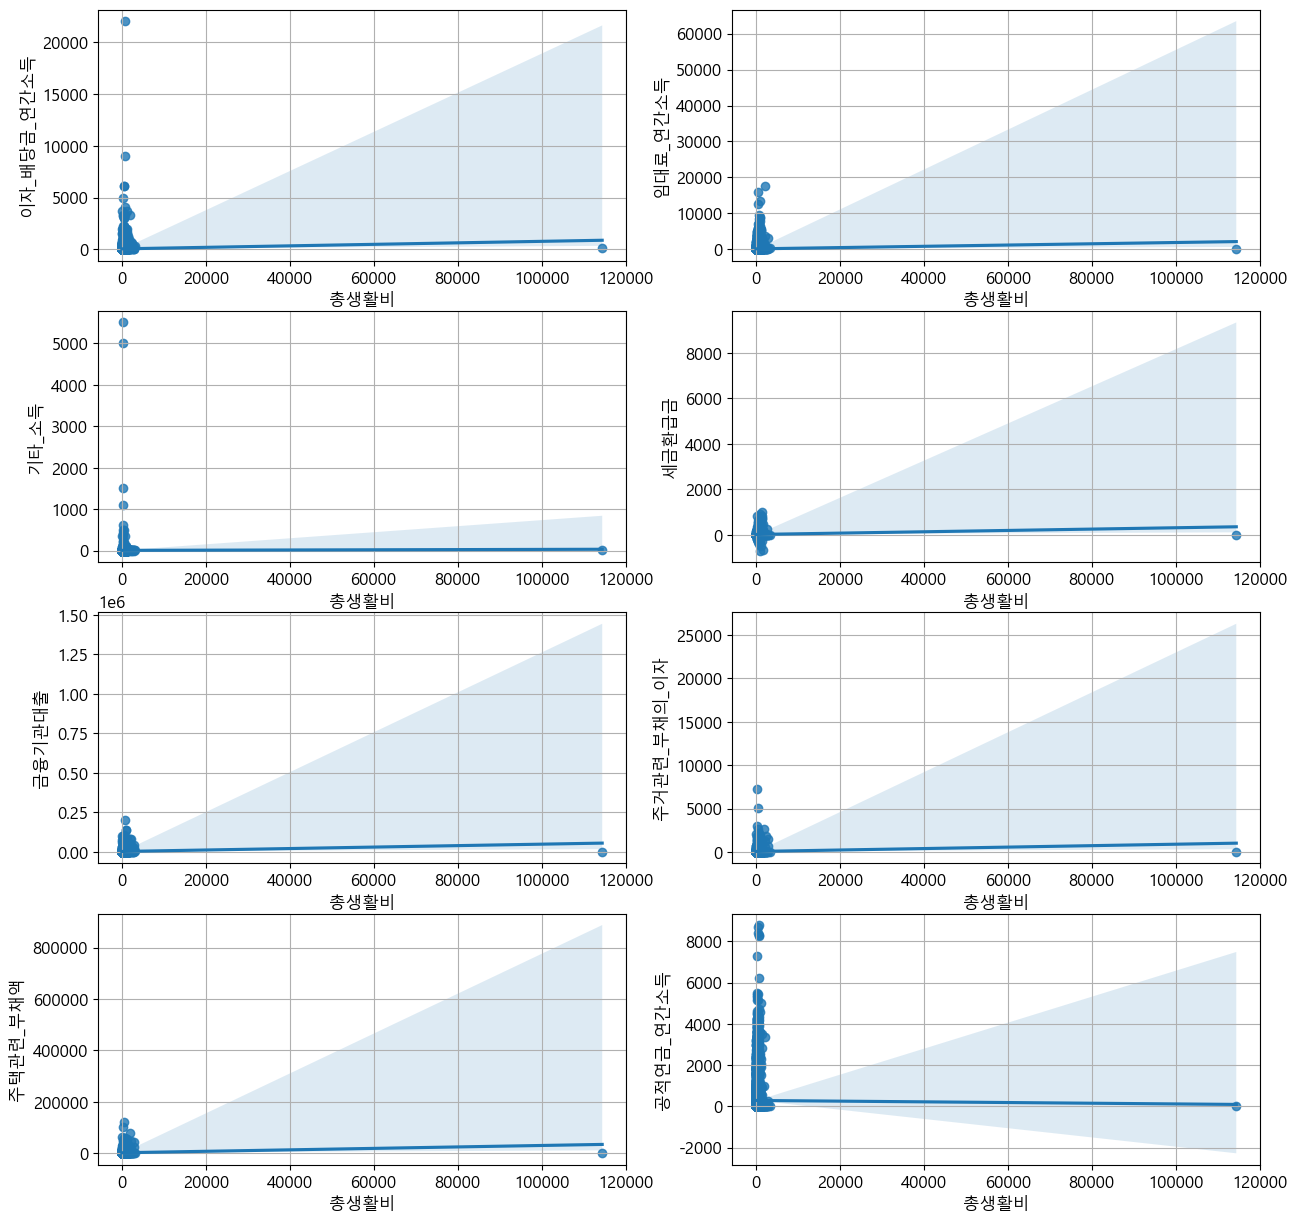

In [14]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(re_df1.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid(True)

plt.show()
plt.close()

각 컬럼 별 이상치 찾기(2)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 boxplot 그래프 조회 

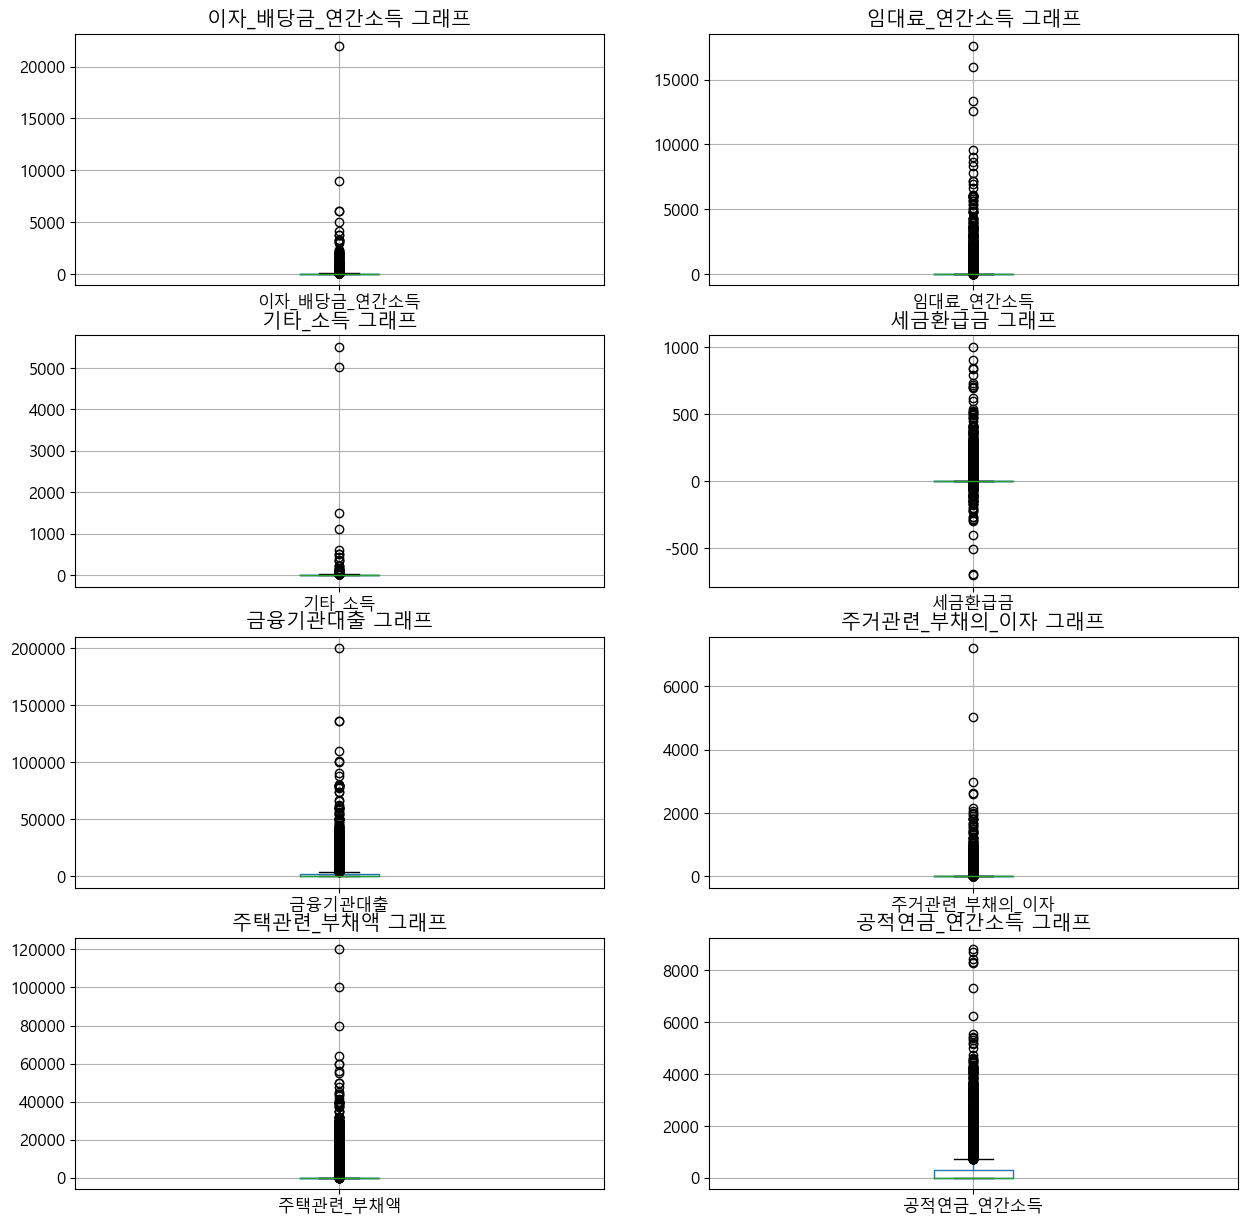

In [15]:
# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    re_df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid(True)
plt.show()

In [16]:
des_df = df.describe()
des_df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,6786.000000,7865.000000
mean,329.821615,55.537889,129.335537,8.455906,14.505976,2958.797203,53.391736,2055.432508,288.638525
std,1314.994181,347.927318,644.462635,87.829841,59.830654,8277.347380,195.465924,5901.854652,675.030701
min,23.000000,0.000000,0.000000,0.000000,-700.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,228.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,435.000000,20.000000,0.000000,8.000000,0.000000,1700.000000,0.000000,0.000000,288.000000
max,114446.000000,22025.000000,17640.000000,5506.000000,1000.000000,200000.000000,7200.000000,120000.000000,8796.000000


regplot, boxplot 조회 결과

- x값으로 넣을 종속변수(총생활비)에서 1건만 비정상으로 높은 수치 확인되어 제거하고 진행

- y값으로 넣을 독립변수들 중 이상치가 각 컬럼에서 발견되어 프로젝트 참가자들 주관적 판단에 의해 제거하기로 결정

- 컬럼별 제거 데이터 
     - 이자_배당금_연간소득 상위이상치 2건
     - 임대료_연간소득 상위이상치 4건
     - 기타_소득 상위이상치 4건
     - 주택관련_부채액 상위이상치 3건
     - 공적연금_연간소득 상위이상치 7건
     - 세금환급금 상위이상치 8건
     - 금융기관대출 상위이상치 2건
     - 주거관련_부채의_이자 상위이상치 4건

- 종속변수,독립변수 포함해서 총35건의 데이터 제거하였음

이상치 행 제외 후 재조회

In [17]:
df2=re_df1.query('(총생활비 < 5000) and (이자_배당금_연간소득 < 7000) and (임대료_연간소득 < 11000) and\
                 (기타_소득 < 1000) and (주택관련_부채액 <75000) and (공적연금_연간소득 <6000) and \
                 (세금환급금 > -500 and 세금환급금 < 750)\
                 and (금융기관대출 < 125000) and (주거관련_부채의_이자 < 2500)')
df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


이상치 데이터 제거후 추세선이 올라오는지 regplot으로 그래프 재확인하기

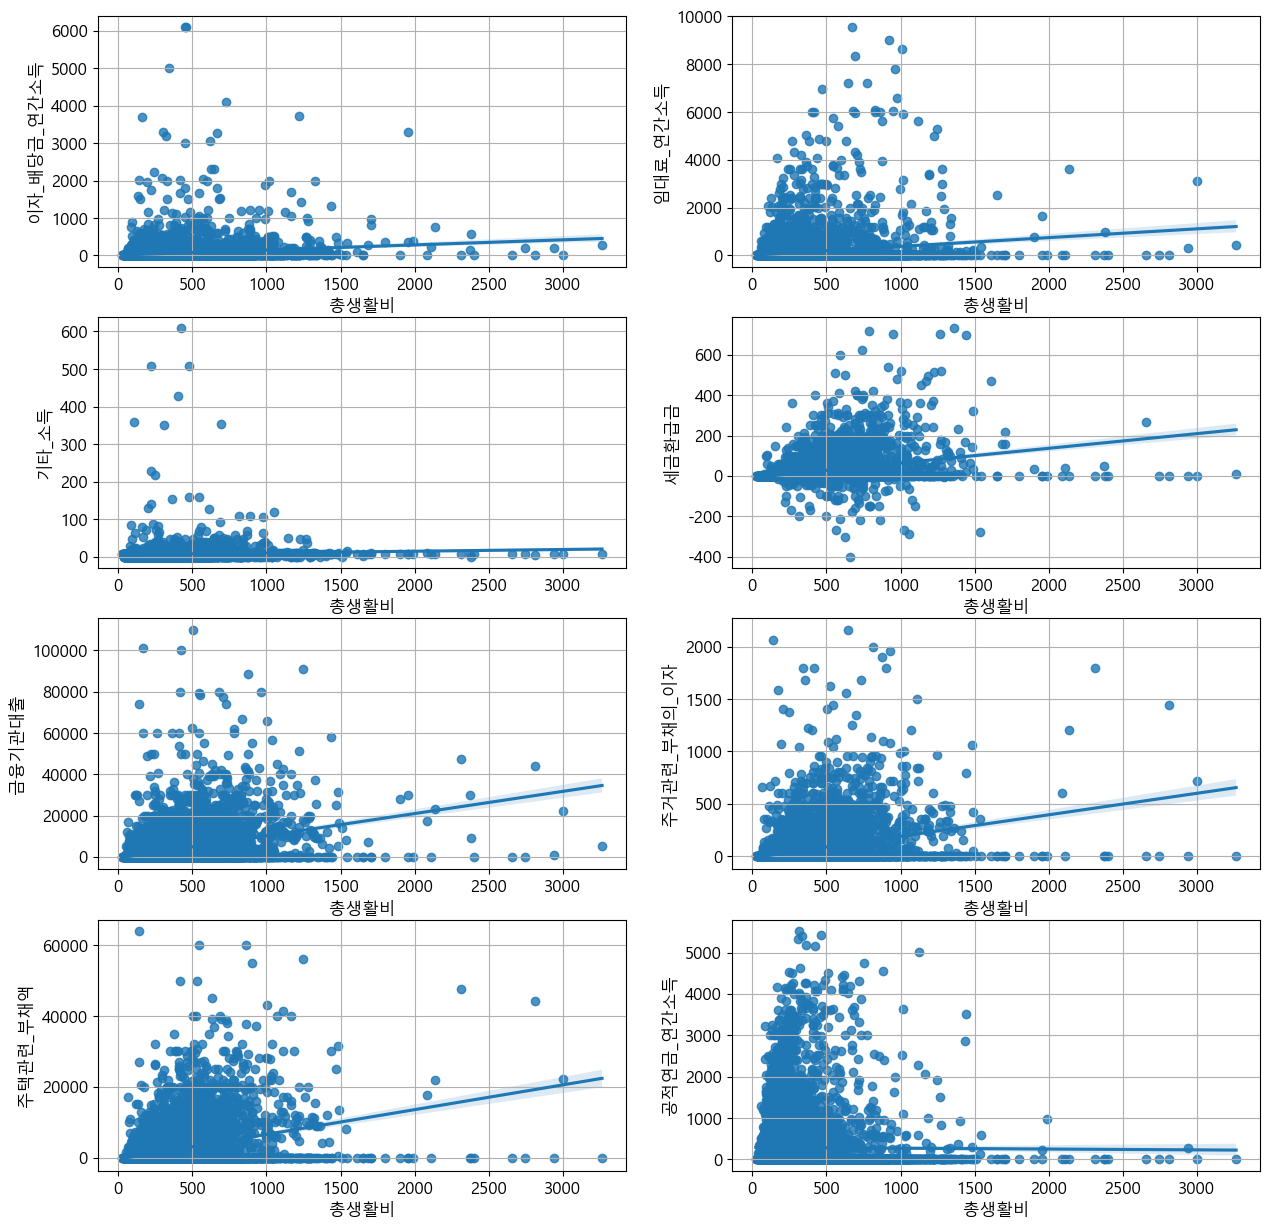

In [18]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(df2.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=df2, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid(True)

plt.show()
plt.close()

In [19]:
des_df2 = df2.describe().round(3)
des_df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000
mean,313.272,51.184,121.446,6.765,14.121,2854.026,50.685,1725.766,281.977
std,266.982,222.232,550.526,15.660,54.118,7545.379,160.491,5149.011,634.145
min,23.000,0.000,0.000,0.000,-400.000,0.000,0.000,0.000,0.000
25%,121.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,227.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000
75%,433.000,20.000,0.000,8.000,0.000,1600.000,0.000,0.000,288.000
max,3265.000,6100.000,9552.000,608.000,730.000,110000.000,2160.000,64000.000,5520.000


#전처리2. 정규성/등분산성/독립성 확인

비모수적인 방법 사용, 로버스트(robust) 통계 기법 사용, 대규모 데이터셋 사용, 통계 기법과 목적에 따른 유연성(회귀분석의 예측 모델링이 목적)에 따라 정규성/등분산성/독립성 확인을 제외

현재 대규모 데이터셋을 사용하기 때문에 정규성, 등분산성, 독립성 확인은 제외하기로 결정

진석님 의견: 선형회귀->정규분포 가정으로 대체를 해야하는지 확인해보기

In [32]:
# 정규화 하기 전 신뢰구간 구하기

df2Col = list(df2.columns)
# df2Col
for cc in df2Col:
    print("%s 신뢰구간"%cc)
    getConfidenceInterval(df2["%s"%cc])
    # print('\n')

총생활비 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    307.358 |
| 상한 |    319.187 |
+------+------------+
이자_배당금_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    46.2607 |
| 상한 |     56.107 |
+------+------------+
임대료_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |     109.25 |
| 상한 |    133.642 |
+------+------------+
기타_소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    6.41806 |
| 상한 |    7.11188 |
+------+------------+
세금환급금 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    12.9223 |
| 상한 |      15.32 |
+------+------------+
금융기관대출 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    2686.87 |
| 상한 |    3021.18 |
+------+------------+
주거관련_부채의_이자 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    47.1293 |
| 상한 |    54.2401 |
+------+------------+
주택관련_부채액 신뢰구간
+------+------------+
|   

## #전처리3. 표준화-정규화(Scaling)

표준화(정규화)를 통해 서로 다른 단위나 범위를 가진 데이터를 동일한 기준으로 맞춤으로써, 데이터 분석이나 머신러닝 모델의 성능을 향상.

다만, 현재 사용중인 데이터에는 명목형(범주형)변수를 제외한 경우인 만큼 더미변수화 시킬 필요가 없다고 판단, 스케일링만 진행하기로 결정.

시간이 된다면 (표준화 적용한 결과/표준화를 적용하지 않은 결과의 차이를 비교, 학습)

데이터 정규화하기

In [33]:
scaler=StandardScaler()
df3=df2.copy()
df3_std=df2.copy()

df3_std['총생활비'] = scaler.fit_transform(df3_std[['총생활비']])
df3_std['이자_배당금_연간소득'] = scaler.fit_transform(df3_std[['이자_배당금_연간소득']])
df3_std['임대료_연간소득'] = scaler.fit_transform(df3_std[['임대료_연간소득']])
df3_std['기타_소득'] = scaler.fit_transform(df3_std[['기타_소득']])
df3_std['세금환급금'] = scaler.fit_transform(df3_std[['세금환급금']])
df3_std['금융기관대출'] = scaler.fit_transform(df3_std[['금융기관대출']])
df3_std['주거관련_부채의_이자'] = scaler.fit_transform(df3_std[['주거관련_부채의_이자']])
df3_std['주택관련_부채액'] = scaler.fit_transform(df3_std[['주택관련_부채액']])
df3_std['공적연금_연간소득'] = scaler.fit_transform(df3_std[['공적연금_연간소득']])

df3_std

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,-0.143361,-0.230332,-0.220614,0.015010,-0.260949,0.947127,-0.315830,-0.335186,-0.444685
1,-0.278210,-0.230332,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
2,-0.589112,-0.230332,-0.075289,0.015010,-0.260949,1.477286,4.170679,3.646416,0.406910
3,0.853023,0.399681,-0.220614,0.142735,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
4,-0.855064,-0.005327,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
...,...,...,...,...,...,...,...,...,...
7860,0.264932,-0.230332,-0.220614,-0.368166,1.032604,0.019347,0.282372,0.247487,-0.444685
7861,1.504793,-0.230332,0.978317,-0.368166,1.402191,4.923324,-0.315830,-0.335186,-0.444685
7862,1.055296,-0.230332,7.045634,-0.368166,-0.260949,3.060741,0.101665,4.704356,-0.444685
7863,0.931685,-0.050328,-0.220614,-0.432028,-0.260949,1.212207,1.927425,1.995508,-0.444685


## 회귀분석

In [34]:
# cls=list(df2.columns)
# cls.remove("총생활비")
# cls
# ols_result = myOls(df2, x=cls, y="총생활비")
# print(ols_result.summary)
# ols_result.table
# ols_result.result
# ols_result.goodness
# ols_result.varstr